# Movie Recommendation System
 
### Part 1: Recommendations based on content
### Part 2: Semantic mapping of data using SOM 

Ομάδα 26

Γεωργούτσος Αθανάσιος: 03117151

Βαλουξής Σπυρίδων: 03117003



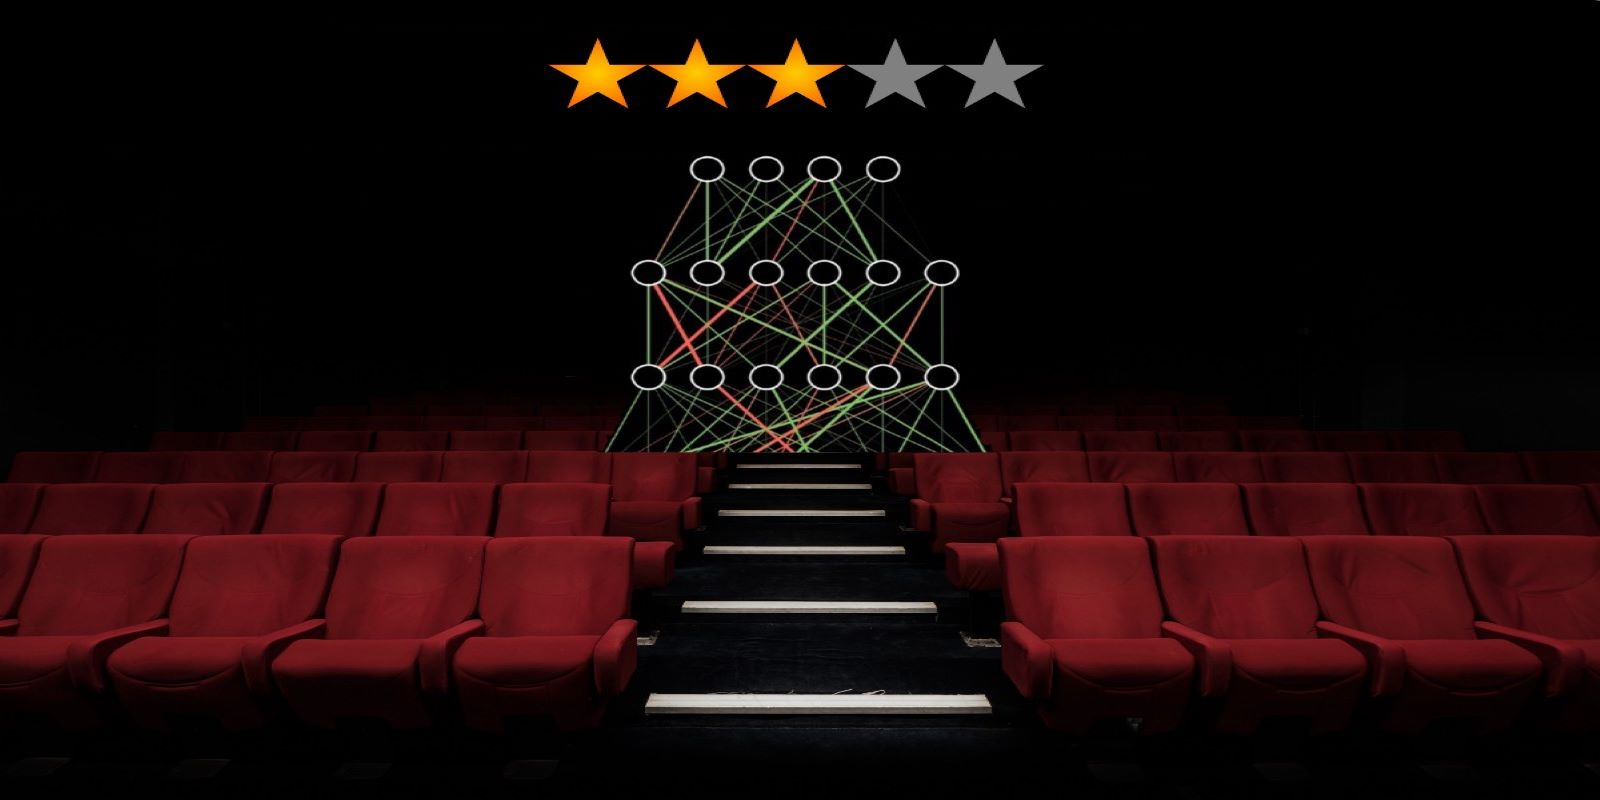

## Requirements

In [1]:
!pip install --upgrade pip
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade nltk
!pip install --upgrade scikit-learn
!pip install --upgrade joblib
!pip install -U gensim
!pip install --upgrade somoclu

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm, notebook
import string
from joblib import Parallel, delayed
from scipy import sparse

import somoclu
import matplotlib
# we will plot inside the notebook and not in separate window
%matplotlib inline
import gensim.downloader as api
import joblib

import nltk
from nltk.corpus import stopwords
from nltk.corpus import names 
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.probability import FreqDist

# for tokenizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('names')
nltk.download('wordnet')
nltk.download('omw-1.4')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


## Loading Dataset

Our dataset is based on [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). It contains 22301 movie descriptions, which consist of the title, genre keywords and a synopsis of the plot. Initially, we load the dataset to a dataframe below.

In [3]:
dataset_url = "https://drive.google.com/uc?export=download&id=1-tN5rC1QCgwqL67cvIXdMbtd-Xf9Xqow"
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3)

As instructed by the lab, **we are going to work on a subset of 5000 movies of the above dataset**.

Below, using our team number as the team_seed_number, the given code is going to provide us with our 5000 movies. Then, we keep the information about our movies in the following data structures. 

In [5]:
# seed number for subset of the dataset
team_seed_number = 26

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1-oeMf7BFmiH70XObgC9WOTo-a9cDJZwP"
df_data_2 = pd.read_csv(movie_seeds_url, header=None)

# choose our subset
my_index = df_data_2.iloc[team_seed_number,:].values

titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries
corpus_df = pd.DataFrame(corpus) # dataframe version of corpus

- The array **titles** contains the titles of the movies. E.g.: 'Sid and Nancy'.
- The array **categories** contains the genres of the movie, using a string. E.g.: '"Tragedy",  "Indie",  "Punk rock",  "Addiction Drama",  "Cult",  "Musical",  "Drama",  "Biopic \[feature\]",  "Romantic drama",  "Romance Film",  "Biographical film"'. It is a  comma separated list of strings, where every string is a genre.
- The matrix **catbins** contains the genres of the movies in binary form ([one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)). Dimensions: 5.000 x 322 (which means there are 322 different genre keywords). Value 1 means the movie is included in this genre, 0 otherwise.
- The matrix **summaries** and the list **corpus** include the synopses of the movies. Every synopsis is a string. E.g.: *'The film is based on the real story of a Soviet Internal Troops soldier who killed his entire unit  as a result of Dedovschina. The plot unfolds mostly on board of the prisoner transport rail car guarded by a unit of paramilitary conscripts.'*
- The dataframe **corpus_df**, which is *corpus* in dataframe form. Summaries are located in column 0.


**ID** of a movie is the index of it in the above . E.g.: here, follows the information of the movie with ID=999.

# Part 1: Movie recommendation system based on content
<img src="http://clture.org/wp-content/uploads/2015/12/Netflix-Streaming-End-of-Year-Posts.jpg" width="70%">

Here, we develop a content-based movie recommender system (https://en.wikipedia.org/wiki/Recommender_system). The goal of a recommender system is to suggest a small number of objects from a larger collection to a user, which should be appealing to him, based on certain criteria. Movie reccomender systems are divided based on the filtering of the objects for suggestion. The two main categories are collaborative filtering, where the system suggests objects that have been evaluated positively by users with similar evaluation history with our user, and content based filtering, where the system suggests objects with similar content with the ones he has previously positively evaluated.

Our following movie recommender system is based **on the content of the movies**, and more specifically on their synopses (**corpus**).  


## Preprocessing

Here, we try to clear the movies' summaries from words that do not provide useful information regarding their plot. 

The Preprocessing phase consists of the following:


*   Remove words starting with upper case characters
*   Make all characters lower case
*   Remove stopwords
*   Remove punctuations
*   Remove short strings (1 or 2 characters)

As a reference for the below preprocessing procedures, we are going to show the preprocessing effects on the synopsis of *Requiem for a Dream*, which can be seen above with ID=999.

### Preprocessing phase

####Removing words starting with upper case character
After testing our initial recommender with many random movie IDs, we have spotted a problem.

ID=999: one of the protagonists of Requiem for a Dream is named Harry and the top recommendations are movies with a protagonist named Harry, while their topics may be completely different (e.g. Harry Potter and the Chamber of Secrets). 

Initially, to get over the problem we chose to remove famous English names but then we ran into the same problem just with Indian names, for example (check summary of movie with ID=1786). 

That's why we remove every word that starts with an upper case letter.
After observing many summaries, we realised that doing so, we remove all names and mainly useless words for our purpose (e.g. On, They, In etc.). Maybe we lose some city names or some useful words in case a sentence starts with them, but removing every word starting with an upper case letter not only does improve our system's recommendation, but also reduces significantly the preprocessing time. Checking every word of the movie summaries against a large names list is very time consuming.

In [6]:
def remove_names(corpus):
  res = []
  # remove names
  for i in tqdm(range(0,len(corpus))):
    word_tokens = word_tokenize(corpus[i])
    keep_words = [word for word in word_tokens if (word[0].islower() or (not (word in names.words('male.txt') or word in names.words('female.txt'))))]
    res.append(' '.join(keep_words))

  return res

def remove_upper(corpus):
  res = []
  # remove names
  for i in tqdm(range(0,len(corpus))):
    word_tokens = word_tokenize(corpus[i])
    keep_words = [word for word in word_tokens if word[0].islower()]
    res.append(' '.join(keep_words))

  return res

res0 = remove_upper(corpus)
print()
print('Requiem for a Dream synopsis after removing words starting with uppercase transformation:')
print(res0[999])

100%|██████████| 5000/5000 [00:12<00:00, 389.82it/s]


Requiem for a Dream synopsis after removing words starting with uppercase transformation:
film charts three seasons in the lives of her son s girlfriend and s friend story begins in summer an elderly widow living alone in spends her time watching infomercials hosted by a phone call announces that she will be invited to be a participant on a game show she becomes obsessed with regaining the youthful appearance she possesses in a photograph from graduation her proudest moment order to fit into her old red dress the favorite of her deceased husband she begins taking a regimen of prescription weight-loss amphetamine pills throughout the day and a sedative at night s warnings about amphetamine addiction she passionately insists that the chance to be on television has given her a reason to live her invitation does not arrive over the fall she increases her dosage but begins suffering from amphetamine psychosis hallucinating that she is the principal subject of the game show and that her ref

#### Lower case transformation

In [7]:
def make_lowercase(corpus):
  res = []
  # transform all characters in lower case
  for i in tqdm(range(0,len(corpus))):
    res.append(corpus[i].lower())
  return res

res1 = make_lowercase(res0)
print()
print('Requiem for a Dream synopsis after lower case transformation:')
print(res1[999])

100%|██████████| 5000/5000 [00:00<00:00, 260655.01it/s]


Requiem for a Dream synopsis after lower case transformation:
film charts three seasons in the lives of her son s girlfriend and s friend story begins in summer an elderly widow living alone in spends her time watching infomercials hosted by a phone call announces that she will be invited to be a participant on a game show she becomes obsessed with regaining the youthful appearance she possesses in a photograph from graduation her proudest moment order to fit into her old red dress the favorite of her deceased husband she begins taking a regimen of prescription weight-loss amphetamine pills throughout the day and a sedative at night s warnings about amphetamine addiction she passionately insists that the chance to be on television has given her a reason to live her invitation does not arrive over the fall she increases her dosage but begins suffering from amphetamine psychosis hallucinating that she is the principal subject of the game show and that her refrigerator is a menacing livi

#### Removing stopwords

In [8]:
def remove_stopwords(corpus):
  res = []
  # remove stopwords
  for i in tqdm(range(0,len(corpus))):
    stop_words = stopwords.words('english')
    word_tokens = word_tokenize(corpus[i])
    keep_words = [word for word in word_tokens if not word in stop_words]
    res.append(' '.join(keep_words))

  return res  

res2 = remove_stopwords(res1)
print()
print('Requiem for a Dream synopsis after removing stopwords:')
print(res2[999])

100%|██████████| 5000/5000 [00:08<00:00, 585.19it/s]


Requiem for a Dream synopsis after removing stopwords:
film charts three seasons lives son girlfriend friend story begins summer elderly widow living alone spends time watching infomercials hosted phone call announces invited participant game show becomes obsessed regaining youthful appearance possesses photograph graduation proudest moment order fit old red dress favorite deceased husband begins taking regimen prescription weight-loss amphetamine pills throughout day sedative night warnings amphetamine addiction passionately insists chance television given reason live invitation arrive fall increases dosage begins suffering amphetamine psychosis hallucinating principal subject game show refrigerator menacing living monster heroin addict together fellow addicts enters illegal drug trade around money make summer hope open fashion store designs dreams making mother proud escaping street beginning fall caught middle drug gang assassination must use money post bail drug-related violence a

#### Removing punctuations and special characters

In [9]:
def remove_punctuations(corpus):
  res = []
  # remove punctuations and special characters
  for i in tqdm(range(0,len(corpus))):
    puns = list(string.punctuation)
    puns.append('’')
    word_tokens = word_tokenize(corpus[i])
    keep_words = [word for word in word_tokens if not word in puns]
    res.append(' '.join(keep_words))
  return res  

res3 = remove_punctuations(res2)
print()
print('Requiem for a Dream synopsis after removing punctuations and special characters:')
print(res3[999])

100%|██████████| 5000/5000 [00:03<00:00, 1460.27it/s]


Requiem for a Dream synopsis after removing punctuations and special characters:
film charts three seasons lives son girlfriend friend story begins summer elderly widow living alone spends time watching infomercials hosted phone call announces invited participant game show becomes obsessed regaining youthful appearance possesses photograph graduation proudest moment order fit old red dress favorite deceased husband begins taking regimen prescription weight-loss amphetamine pills throughout day sedative night warnings amphetamine addiction passionately insists chance television given reason live invitation arrive fall increases dosage begins suffering amphetamine psychosis hallucinating principal subject game show refrigerator menacing living monster heroin addict together fellow addicts enters illegal drug trade around money make summer hope open fashion store designs dreams making mother proud escaping street beginning fall caught middle drug gang assassination must use money post ba

#### Removing short strings

In [10]:
def remove_shorts(corpus):
  res = []
  # remove short strings
  for i in tqdm(range(0,len(corpus))):
    word_tokens = word_tokenize(corpus[i])
    keep_words = [word for word in word_tokens if len(word)>2]
    res.append(' '.join(keep_words))
  return res

res4 = remove_shorts(res3)
print()
print('Requiem for a Dream synopsis after removing strings with 1 or 2 characters:')
print(res4[999])

100%|██████████| 5000/5000 [00:05<00:00, 995.99it/s] 


Requiem for a Dream synopsis after removing strings with 1 or 2 characters:
film charts three seasons lives son girlfriend friend story begins summer elderly widow living alone spends time watching infomercials hosted phone call announces invited participant game show becomes obsessed regaining youthful appearance possesses photograph graduation proudest moment order fit old red dress favorite deceased husband begins taking regimen prescription weight-loss amphetamine pills throughout day sedative night warnings amphetamine addiction passionately insists chance television given reason live invitation arrive fall increases dosage begins suffering amphetamine psychosis hallucinating principal subject game show refrigerator menacing living monster heroin addict together fellow addicts enters illegal drug trade around money make summer hope open fashion store designs dreams making mother proud escaping street beginning fall caught middle drug gang assassination must use money post bail dr

#### Lemmatization

In [11]:
def lemmatize(corpus):
  res = []
  wordnet_lemmatizer = WordNetLemmatizer()
  for i in tqdm(range(0,len(corpus))):
    word_tokens = word_tokenize(corpus[i])
    keep_words = [wordnet_lemmatizer.lemmatize(word) for word in word_tokens]
    res.append(' '.join(keep_words))

  return res

res5 = lemmatize(res4)
print()
print('Requiem for a Dream synopsis after lemmatization:')
print(res5[999])

100%|██████████| 5000/5000 [00:08<00:00, 598.46it/s]


Requiem for a Dream synopsis after lemmatization:
film chart three season life son girlfriend friend story begin summer elderly widow living alone spends time watching infomercial hosted phone call announces invited participant game show becomes obsessed regaining youthful appearance posse photograph graduation proudest moment order fit old red dress favorite deceased husband begin taking regimen prescription weight-loss amphetamine pill throughout day sedative night warning amphetamine addiction passionately insists chance television given reason live invitation arrive fall increase dosage begin suffering amphetamine psychosis hallucinating principal subject game show refrigerator menacing living monster heroin addict together fellow addict enters illegal drug trade around money make summer hope open fashion store design dream making mother proud escaping street beginning fall caught middle drug gang assassination must use money post bail drug-related violence arrest make hard obtain

In [13]:
# function for all our clearing actions
def preprocessing(corpus):
  # pass every stage of clearing from above
  res = remove_upper(corpus)
  res = make_lowercase(res)
  res = remove_stopwords(res)
  res = remove_punctuations(res)
  res = remove_shorts(res)
  res = lemmatize(res)
  return res

# get the preprocessed corpus
corpus_pre = preprocessing(corpus)

100%|██████████| 5000/5000 [00:06<00:00, 786.38it/s]


## Convert to TFIDF

Converting corpus to a tf-idf representation. Our initial TfidfVectorizer is not optimized.

In [14]:
# create sparse tf_idf representation
vectorizer = TfidfVectorizer()
vectorizer.fit(corpus_pre)
corpus_tf_idf_plain = vectorizer.transform(corpus_pre)

print(corpus_tf_idf_plain.shape)

(5000, 24916)


Even though many of the preprocessing procedures that we implemented above can be scheduled with the TfidfVectorizer(). The custom preprocessing was a direct instruction of the course's lab, for transformations that do not require knowledge of the whole dataset. This kind of transformations (like removing more/less frequent words in all the summaries) follows in the tf-idf optimization part.

## Recommender

Here we implement the `content_recommender` function that recommends `max_recommendations` movies based on a `target movie` sorted by their cosine similarity.




In [15]:
def content_recommender(target_movie, max_recommendations, corpus_type):
  target_tf_idf = corpus_type[target_movie]
  total = corpus_type.shape[0]

  # array to store cosine similarity scores
  sims = np.zeros(total)
  
  # compute cosine similarities
  for i in tqdm(range(total)):
    sims[i] = cosine_similarity(target_tf_idf, corpus_type[i])

  # sort movies based on cosine similarity
  sorted_idx = np.argsort(sims)[::-1]

  # Output details of the target movie
  print()
  print("Target movie details")
  print("Id: %d" %target_movie)
  print("Title: %s" %titles[target_movie][0])
  print("Synopsis: %s" %corpus[target_movie])
  print("Categories: %s" %(",".join(categories[target_movie])))

  # Check that best similarity is found for the best movie itself
  #assert sorted_idx[0] == target_movie
  #assert round(sims[target_movie],5) == 1.00000

  # Output details of the recommended movies
  for movie in range(1,max_recommendations+1):
    movie_id = sorted_idx[movie]
    print()
    print("No."+str(movie)+" recommended movie details")
    print("Cosine similarity: "+str(round(sims[movie_id],4)))
    print("Id: %d" %movie_id)
    print("Title: %s" %titles[movie_id][0])
    print("Summary: %s" %corpus[movie_id])
    print("Categories: %s" %(",".join(categories[movie_id])))  

### Initial Recommendations 
Checking our system's suggestions for input movie "Requiem for a Dream".

In [16]:
content_recommender(999, 5, corpus_tf_idf_plain)

100%|██████████| 5000/5000 [00:04<00:00, 1102.54it/s]


Target movie details
Id: 999
Title: Requiem for a Dream
Synopsis: The film charts three seasons in the lives of Sara Goldfarb , her son Harry , Harry’s girlfriend Marion Silver , and Harry’s friend Tyrone C. Love . The story begins in summer; Sara Goldfarb, an elderly widow living alone in Brighton Beach, Brooklyn, spends her time watching infomercials hosted by Tappy Tibbons . After a phone call announces that she will be invited to be a participant on a game show, she becomes obsessed with regaining the youthful appearance she possesses in a photograph from Harry's graduation, her proudest moment. In order to fit into her old red dress, the favorite of her deceased husband Seymour, she begins taking a regimen of prescription weight-loss amphetamine pills throughout the day and a sedative at night. Despite Harry’s warnings about amphetamine addiction, she passionately insists that the chance to be on television has given her a reason to live. When her invitation does not arrive over 

## TfidfVectorizer Optimization

Now we optimize our `TfidfVectorizer` researching our `content_recommenders's` suggestions and changing the vectorizer's parameters in order to improve our recommender's performance. Since many transformations have already been applied in the preprocessing phase, here we mainly remove the most and least frequent words. This procedure removes a large portion of the unique words found in the summaries.

Because we could not check the new results for 5000 movies, we checked specific movie IDs, which are the ones that we use as examples for our observations in the following parts.

Another goal we had in mind was to reduce the dimensions of our vector, preparing for the next parts of the exercise, but not so much that the suggestions of our system become considerably worse. 




In [17]:
# create sparse tf_idf representation (optimized)
vectorizer = TfidfVectorizer(min_df=0.005, max_df=0.3)
vectorizer.fit(corpus_pre)
corpus_tf_idf_optimized = vectorizer.transform(corpus_pre)

print(corpus_tf_idf_optimized.shape)

(5000, 3450)


In [18]:
content_recommender(999, 5, corpus_tf_idf_optimized)

100%|██████████| 5000/5000 [00:04<00:00, 1237.57it/s]


Target movie details
Id: 999
Title: Requiem for a Dream
Synopsis: The film charts three seasons in the lives of Sara Goldfarb , her son Harry , Harry’s girlfriend Marion Silver , and Harry’s friend Tyrone C. Love . The story begins in summer; Sara Goldfarb, an elderly widow living alone in Brighton Beach, Brooklyn, spends her time watching infomercials hosted by Tappy Tibbons . After a phone call announces that she will be invited to be a participant on a game show, she becomes obsessed with regaining the youthful appearance she possesses in a photograph from Harry's graduation, her proudest moment. In order to fit into her old red dress, the favorite of her deceased husband Seymour, she begins taking a regimen of prescription weight-loss amphetamine pills throughout the day and a sedative at night. Despite Harry’s warnings about amphetamine addiction, she passionately insists that the chance to be on television has given her a reason to live. When her invitation does not arrive over 

Get the `tfidf` scores for later stages.

In [ ]:
tfidf=[]
for i in tqdm(range(5000)):
  tfidf.append(dict(zip(vectorizer.get_feature_names_out(), corpus_tf_idf_optimized.toarray()[i])))

100%|██████████| 5000/5000 [03:37<00:00, 23.04it/s]


## Deep learning: creating corpora using word emmbeddings


The approach to construct our recommender based on a tfidf vectorizer has, as it can be observed, disadvanages. Here we will try to use **word embeddings** provided by the **Word2Vec model**.


Because our dataset is too small to produce our own embeddings we load some ready, pretrained embeddings (using the deep learning methodology called Transfer Learning).

#### Gensim-data Embeddings

Gensim includes several pretrained Word2Vec embeddings models. Below we print their list.

In [ ]:
print(list(api.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


 ### Corpus based on embeddings


In order to include the knowledge of the pretrained embeddings in our own corpus we do the following:

For each movie summary $d$, which consists of $N_d$ words $w_i$, each word's  $tfidf$ is:

$$ tfidf(w_i) = tf(w_i,d) \cdot idf(w_i)$$

Each word $w_i$ has a vector $W2V(w_i)$ from the embeddings model with dimension $m$. 

For each movie d, we can create a vector $W2V(d)$ with $m$ dimensions using $tfidf(w_i)$ as a weight for each embedding $W2V(w_i)$:

$$ W2V(d) = \frac{tfidf(w_1)\cdot W2V(w_i) + tfidf(w_2)\cdot W2V(w_2) + \dotsc  + tfidf(w_{N_{d}})\cdot W2V(w_{N_{d}})}{tfidf(w_1)+tfidf(w_2)+ \dotsc + tfidf(w_{N_{d}})}$$


#### build_tfw2v

Below, we implement the function `build_tfw2v` with arguments:
- `corpus`: our preprocessed dataset,
- `vectors`: the selected embeddings model and 
- `embeddings_size`: the embedding's length $m$.

This function returns a sparse array of size 5000 (all of our movies) x $m$ (embedding's dimensions). This array will be different based on what embeddings model we use.

We use 3 Word2vec embedding models with different contents and sizes from Gensim, in order to compare their use and results. (Intuitively and after experimentation, larger sizes produce better results, so we use 2 models with size 300 and one with size 25, to showcase the difference)

In [ ]:
def build_tfw2v(corpus_pre, vectors, embeddings_size):
  ret = []
  for word in vectorizer.get_feature_names_out():
      try:
        vectors[word]
      except:
        vectors[word] = np.zeros(embeddings_size)
  for movie_id in tqdm(range(5000)):
    up = np.zeros(embeddings_size)
    down = 0
    for word in vectorizer.get_feature_names_out():
      up = up + tfidf[movie_id][word]*vectors[word]
      down = down + tfidf[movie_id][word]
    if not up.any():
      ret.append(up)
    else:
      ret.append(up/down)
  return sparse.csr_matrix(np.array(ret))


In [ ]:
model1 = api.load("glove-twitter-25")
model2 = api.load("fasttext-wiki-news-subwords-300")
model3 = api.load("word2vec-google-news-300")
new_corpus1 = build_tfw2v(corpus_pre, model1, model1.vector_size)
new_corpus2 = build_tfw2v(corpus_pre, model2, model2.vector_size)
new_corpus3 = build_tfw2v(corpus_pre, model3, model3.vector_size)

[==================================================] 100.0% 104.8/104.8MB downloaded
[==================================================] 100.0% 958.5/958.4MB downloaded
[==================================================] 100.0% 1662.8/1662.8MB downloaded


100%|██████████| 5000/5000 [02:15<00:00, 36.93it/s]


In [ ]:
# here we persist these new corpora to files, to avoid the above slow downloading
joblib.dump(new_corpus1, 'new_corpus1.pkl')
joblib.dump(new_corpus2, 'new_corpus2.pkl')
joblib.dump(new_corpus3, 'new_corpus3.pkl')

['new_corpus3.pkl']

In [ ]:
# here we load the new word2vec corpora from the files above
new_corpus1 = joblib.load('new_corpus1.pkl')
new_corpus2 = joblib.load('new_corpus2.pkl')
new_corpus3 = joblib.load('new_corpus3.pkl')

In [ ]:
#suggestions using model 3
content_recommender(999, 5, new_corpus3)

100%|██████████| 5000/5000 [00:04<00:00, 1198.70it/s]


Target movie details
Id: 999
Title: Requiem for a Dream
Synopsis: The film charts three seasons in the lives of Sara Goldfarb , her son Harry , Harry’s girlfriend Marion Silver , and Harry’s friend Tyrone C. Love . The story begins in summer; Sara Goldfarb, an elderly widow living alone in Brighton Beach, Brooklyn, spends her time watching infomercials hosted by Tappy Tibbons . After a phone call announces that she will be invited to be a participant on a game show, she becomes obsessed with regaining the youthful appearance she possesses in a photograph from Harry's graduation, her proudest moment. In order to fit into her old red dress, the favorite of her deceased husband Seymour, she begins taking a regimen of prescription weight-loss amphetamine pills throughout the day and a sedative at night. Despite Harry’s warnings about amphetamine addiction, she passionately insists that the chance to be on television has given her a reason to live. When her invitation does not arrive over 

## Results & Conclusions

## Tfidf based recommender

- In the part about the preprocessing above, we have implemented the necessary procedures, as described in this exercise, and we have discussed about the extra transformations, we chose to apply, extensively.

- `TfidfVectorizer` Optimization
We experiment with the vectorizer's `min_df` and `max_df` parameters and check our recommender's performance based on the new top suggestions for specific IDs. We observe that doing so, the unique words decrease dramatically, which makes our dataset a lot lighter, and helps us later without compromising the system's performance (3450 words remain from the previous 24916 after preprocessing phase).

#### Best Recommendations

Below we present our recommender's best suggestions, choosing some of the movie IDs we tested.

Input movie -> Requiem for a Dream

All the movie suggestions are related to drugs and drug related problems.

In [ ]:
content_recommender(999, 5, corpus_tf_idf_optimized)

100%|██████████| 5000/5000 [00:04<00:00, 1217.41it/s]


Target movie details
Id: 999
Title: Requiem for a Dream
Synopsis: The film charts three seasons in the lives of Sara Goldfarb , her son Harry , Harry’s girlfriend Marion Silver , and Harry’s friend Tyrone C. Love . The story begins in summer; Sara Goldfarb, an elderly widow living alone in Brighton Beach, Brooklyn, spends her time watching infomercials hosted by Tappy Tibbons . After a phone call announces that she will be invited to be a participant on a game show, she becomes obsessed with regaining the youthful appearance she possesses in a photograph from Harry's graduation, her proudest moment. In order to fit into her old red dress, the favorite of her deceased husband Seymour, she begins taking a regimen of prescription weight-loss amphetamine pills throughout the day and a sedative at night. Despite Harry’s warnings about amphetamine addiction, she passionately insists that the chance to be on television has given her a reason to live. When her invitation does not arrive over 

Input movie -> Dead Air

All of our recommender's suggestions are related to ghosts. Most of them are horror Japanese movies too!

In [ ]:
content_recommender(4, 5, corpus_tf_idf_optimized)

100%|██████████| 5000/5000 [00:03<00:00, 1291.27it/s]


Target movie details
Id: 4
Title: Dead Air
Synopsis: Rock , the director of a poor rating TV program, bumps into a female ghost, Tincy , and helps deliver her baby from her dead body. In return, the ghost helps him create a new reality show "Life on the Line", where contestants attempt to overcome deadly traps designed purposely to kill, in hopes to win a cash prize. The show becomes a spectacular hit, but little does he know there's more to Tincy than meets the eye... Dead Air - movieXclusive
Categories: "Horror"

No.1 recommended movie details
Cosine similarity: 0.2634
Id: 901
Title: Hantu Jeruk Purut
Summary: Anna, a mystery writer, goes to Jeruk Purut Cemetery to look for information about the cemetery's legendary ghost, the headless pastor. After she begins writing, she is haunted by the pastor. Fearing for her life, she gives her notes to her fan, the high school student Airin ; not long afterwards she is killed. Airin sees Anna's writing as her road to becoming a famous writer 

Input movie -> Julius Caesar

All of our recommender's suggestions are related to historical figures and battles.

In [ ]:
content_recommender(3842, 5, corpus_tf_idf_optimized)

100%|██████████| 5000/5000 [00:04<00:00, 1232.56it/s]


Target movie details
Id: 3842
Title: Julius Caesar
Synopsis: The series begins in 82 BC when Julius Caesar is an eighteen year old man. He is out in the town with his daughter Julia when news comes that Lucius Cornelius Sulla is just outside the city walls and intends to take the city with his army. The guards sent with the news post death lists on the senate door. When he sees that his father-in-law's name is there he rushes to his house to try and help him escape. However, Pompey arrests him and takes him to Sulla. Caesar's mother, Aurelia, asks Sulla to show him mercy; out of respect for her, he promises to let Caesar live if he divorces his wife, Cornelia, but Caesar refuses. Sulla lets him go but orders Pompey to kill him and bring his heart to him. Pompey follows Caesar and tells him to leave Rome, which he does. Pompey buys a swine's heart from the market and tells Sulla that the heart is Caesar's. Meanwhile, Caesar is captured by pirates who intend to ransom him for money. Whe

Input Movie -> Doctor Dolittle

All of our suggested movies' plots revolve around animals. 

In [ ]:
content_recommender(4202, 5, corpus_tf_idf_optimized)

100%|██████████| 5000/5000 [00:03<00:00, 1264.17it/s]


Target movie details
Id: 4202
Title: Doctor Dolittle
Synopsis: During the early Victorian period, in the town of Puddleby-on-the-Marsh, England, Irishman Matthew Mugg  takes his young friend Tommy Stubbins ([[William Dix  to visit eccentric Doctor John Dolittle. It is Matthew's wish that the Doctor tend to an injured duck Tommy has found and upon arrival, Tommy finds that Dolittle, a former people's physician, lives with a houseful of animals - pigs, sheep, goats, ducks, horses, cows, a chimpanzee named Chee-Chee , a dog named Jip, and a talking parrot named Polynesia  among them. The night is stormy, so Tommy and Matthew stay with Dolittle. He tells them the story of how he learned to speak animal languages, 497 to be exact. He was once a doctor, but he preferred animals to people. He kept a menagerie, which was causing havoc and losing him patients. A casual comment by Polynesia revealed that animals can talk to each other, prompting Dolittle to study the languages of the animals so

#### Inaccurate Recommendations

Below we present our recommender's most inaccurate suggestions, in our opinion.

Input Movie -> Home Alone

Except the first suggestion, which is a family comedy, the rest of the suggestions differ significantly from our input movie.

In [ ]:
content_recommender(3951, 5, corpus_tf_idf_optimized)

100%|██████████| 5000/5000 [00:04<00:00, 1190.11it/s]


Target movie details
Id: 3951
Title: Home Alone
Synopsis:  The McCallister family prepares to spend Christmas in Paris, gathering at Peter and Kate's home in a suburb of Chicago the night before their flight. Eight-year-old Kevin, their youngest son, finds himself the subject of ridicule from his siblings and cousins. After getting into an argument with his older brother Buzz, he is sent to the third floor bedroom of the house, where he wishes his family would disappear. During the night, a power outage resets the alarm clocks and causes the family to oversleep. In the confusion and rush to reach the airport on time, Kevin is left behind and the family does not realize it until they are already airborne. Once in Paris, his mother and father desperately try to book a flight home. Meanwhile, Kevin wakes up to find the house empty and is overjoyed to find that his wish came true. He practises shooting with Buzz's BB gun, jumps on the bed, watches a gangster film, and eats a large serving

Input Movie -> Gidh

The input movie seems to have a summary that mainly includes abstract concepts like love, betrayal etc. and not an extensive desription of the plot like other movies. This partly explains why the first suggested movie is a documentary about judaism and current environmental threats.

In [ ]:
content_recommender(167, 5, corpus_tf_idf_optimized)

100%|██████████| 5000/5000 [00:04<00:00, 1195.45it/s]


Target movie details
Id: 167
Title: Gidh
Synopsis: Love finds Betrayal asking for Justice and Corruption seeks Revenge. All takes place in a world full of Glitz and Glamour, where not is all what it seems. In which humanity of one man is tested and threatened. This film is about Loss, anger and revenge entangled in the lives of Film Stars, Press and Police.
Categories: "Romance Film",  "Action"

No.1 recommended movie details
Cosine similarity: 0.1822
Id: 3154
Title: A Sacred Duty
Summary: The film opens with footage of a NASA rocket launch, an animation of our solar system, and a quote from Deuteronomy 30:19 about choosing between life and death . This is followed by a statement that humanity has not been caring for the Earth properly according to Jewish teachings. Next comes a section about ancient Jewish texts and "sacred words" that provide "specific instructions on how to be custodians of the world in which we live." Throughout the film, quotes from the Torah, illustrated with cl

## Pros & Cons of a Tfidf recommender

#### Pros

*   Excellent performance. After a good preprocessing phase, which removes most of the "junk" words, a Tfidf recommender can help us find movies similar to our input easily, just by sorting the list based on the movie vectors' cosine similarity and returning the movies with the best scores.
*   Fast train and transform runtimes.
*   Easily constructed, with possible implementations with other sorting criteria other than cosine similarity, if needed.
*   Offers many helpful parameters. These include a wide variety of preprocessing transformations that may improve the system's results, depending on the problem.


#### Cons


*   Deals with each word individually, not considering its context, unlike word embeddings. This can result to movie recommendations, that contain similar words in their summaries, but belong to completely different movie genres. 
*   Takes into account every word that "survives" the preprocessing phase, even some semantically uninteresting words that don't contribute to finding relevant suggestions. It is important to mention that the subtraction of every useless word of the summaries is an impossible task (unless someone hand-picks the useless words!!!)







## Word2vec based Recommenders

### Comparison with Word2Vec based Recommenders

- Υλoποιήστε recommenders που βασίζονται σε μεταφορά μάθησης και εμφυτεύματα. Χρησιμοποιήστε παραδείγματα για να υποδείξετε δυνατά και αδύναμα σημεία τους.

- Μπορείτε να σχολιάσετε τα recommenders που βασίζονται στο Word2Vec σε σχέση με το απλό μοντέλο tfidf, εξετάζοντας τις συστάσεις για ίδια ID.

- Μπορείτε επίσης να εξετάσετε συγκριτικά τα Word2Vec recommenders μεταξύ τους και πάλι βασιζόμενοι σε παραδείγματα.

- Οι παρατηρήσεις σας θα βασίζονται στην ανάλυση των ποιοτικών χαρακτηριστικών που είναι η σειρά και το σύνολο των συστάσεων. Ωστόσο, μπορείτε να συμπεριλάβετε και ποσοτικά χαρακτηριστικά όπως τους χρονους loading και συγκρότησης του corpus αλλά και της διαστατικότητας $m$.

Χρησιμοποιήστε όποια μορφή reporting κρίνετε καταλληλότερη: κείμενο, πίνακες, διαγράμματα.


### Strenghts

Recommenders based on Word2Vec embeddings can include knowledge already acquired by huge datasets and help us interpret each word, not only individually, as we did before, but taking into account the word's context.

For example these are the recommendations using the model3 (largest model) for Casino Royale. All the suggested movies include secret services, spies, criminals or money, key characteristics of the casino Royale plot.

In [ ]:
content_recommender(4603, 5, new_corpus3)

100%|██████████| 5000/5000 [00:04<00:00, 1198.02it/s]


Target movie details
Id: 4603
Title: Casino Royale
Synopsis: After killing a traitorous MI6 section chief—who has been selling classified information—and the station chief's contact, James Bond gets his double-0 status. The new agent 007 then goes to Madagascar in pursuit of an international bomb-maker named Mollaka. After a parkour chase to an embassy, Bond kills his target and blows up a part of the building in order to escape. Searching through Mollaka's mobile phone, Bond discovers a text message which he traces to Alex Dimitrios, an associate of banker and terrorist financer Le Chiffre. Le Chiffre's investments involve short-selling stock in successful companies and then engineering terrorist attacks to sink their share prices. Bond travels to Dimitrios's house in the Bahamas and seduces his wife, Solange. While answering a phone call, Solange reveals that her husband is flying to Miami; Bond leaves to pursue him. In Miami, 007 kills Dimitrios during a fight and then follows Le C

### Weaknesses

*   One weakness is that, in order to acquire the knowledge of the huge dataset, it is obligatory to load the embeddings. This comes with a long loading time, that grows larger as the size of the external data that we load.

*   Also, they only contain words found in their vocabulary. This is probably not a problem for larger datasets, but for smaller ones it poses a challenge.

*   On tested movie IDs, the suggestions, in our opinion, are worse for the embeddings than the ones for tf-idf.

Below we observe the suggestions for "Home Alone" as input. It is not difficult to see that their plots do not have almost anything in common with "Home Alone". Most of the movies of the suggestion contain in some context a 'family', similarly to "Home Alone", misleading our recommender system. The reasons are that 'family' can be seen in completely different contexts and, in many cases, it does not have a central role in the movie's plot.






In [ ]:
content_recommender(3951, 5, new_corpus3)

100%|██████████| 5000/5000 [00:04<00:00, 1193.62it/s]


Target movie details
Id: 3951
Title: Home Alone
Synopsis:  The McCallister family prepares to spend Christmas in Paris, gathering at Peter and Kate's home in a suburb of Chicago the night before their flight. Eight-year-old Kevin, their youngest son, finds himself the subject of ridicule from his siblings and cousins. After getting into an argument with his older brother Buzz, he is sent to the third floor bedroom of the house, where he wishes his family would disappear. During the night, a power outage resets the alarm clocks and causes the family to oversleep. In the confusion and rush to reach the airport on time, Kevin is left behind and the family does not realize it until they are already airborne. Once in Paris, his mother and father desperately try to book a flight home. Meanwhile, Kevin wakes up to find the house empty and is overjoyed to find that his wish came true. He practises shooting with Buzz's BB gun, jumps on the bed, watches a gangster film, and eats a large serving

### Comparison with Tfidf recommender

We show the recommendations for our tfidf recommender system and the Word2vec model3 recommender system for the same movie IDs. We will showcase an instance, where each of the systems performs better than the other. We have already stated that the tf-idf recommender is overall better than the Word2vec ones, in our case. 

We observed that for some movies, tf-idf recommender offers the best suggestions, while for others Word2vec recommender is more accurate.

Targeting the movie Dead Air, the recommendations of the tf-fidf system are significantly better. We show the Word2Vec suggestions below. The respective suggestions of tf-idf have been already presented above. We observe that the suggestions of Word2vec are considerably irrelevant to the target movie.

In [ ]:
content_recommender(4, 5, new_corpus3)

100%|██████████| 5000/5000 [00:04<00:00, 1172.06it/s]


Target movie details
Id: 4
Title: Dead Air
Synopsis: Rock , the director of a poor rating TV program, bumps into a female ghost, Tincy , and helps deliver her baby from her dead body. In return, the ghost helps him create a new reality show "Life on the Line", where contestants attempt to overcome deadly traps designed purposely to kill, in hopes to win a cash prize. The show becomes a spectacular hit, but little does he know there's more to Tincy than meets the eye... Dead Air - movieXclusive
Categories: "Horror"

No.1 recommended movie details
Cosine similarity: 0.8276
Id: 1509
Title: LarryBoy and the Bad Apple
Summary: Archibald Asparagus joins Bob the Tomato and Larry the Cucumber on the countertop. He and Larry have received a text message concerning one viewer's struggles with the temptation to play video games all day. Pushing the "frail and helpless" tomato out of the way, they present the story of "LarryBoy and the Bad Apple". As the story begins, Bumblyburg is preparing to c

Targeting the movie Requiem for a Dream, we see that the Word2Vec recommender's results are more accurate.

While the suggestions of tf-idf were also accurate, Word2vec gives the top suggestion spots to movies that do not just share a theme with "Requiem for a Dream", but also evolve the plot under a significantly similar environment. 

Such an example is the movie "Trapped in a Purple Haze". Although this movie is in the top 10 suggestions for tf-idf, here it is located in the third spot. It is important to evaluate even such small changes at the top of the suggestion list, because the top spots are the ones a user will check first, while he may not even proceed to the following suggestions.

Considering the above, Word2vec provides us with better suggestions here.

In [ ]:
content_recommender(999, 5, new_corpus3)

100%|██████████| 5000/5000 [00:04<00:00, 1221.50it/s]


Target movie details
Id: 999
Title: Requiem for a Dream
Synopsis: The film charts three seasons in the lives of Sara Goldfarb , her son Harry , Harry’s girlfriend Marion Silver , and Harry’s friend Tyrone C. Love . The story begins in summer; Sara Goldfarb, an elderly widow living alone in Brighton Beach, Brooklyn, spends her time watching infomercials hosted by Tappy Tibbons . After a phone call announces that she will be invited to be a participant on a game show, she becomes obsessed with regaining the youthful appearance she possesses in a photograph from Harry's graduation, her proudest moment. In order to fit into her old red dress, the favorite of her deceased husband Seymour, she begins taking a regimen of prescription weight-loss amphetamine pills throughout the day and a sedative at night. Despite Harry’s warnings about amphetamine addiction, she passionately insists that the chance to be on television has given her a reason to live. When her invitation does not arrive over 

### Comparison of different models for Word2vec

We tested the suggestions of the Word2vec recommender systems, with the 3 different embedding models from Gensim. Our observations are based on the results for many different movie IDs, but we present below a characteristic example that depicts our case better.

The movie we will use as our target is the American Gangster. The plot of the movie revolves around a usual police case, where the criminal is a gangster dealing drugs, for large amounts of money.

#### New_corpus1 ("glove-twitter-25" model)

Here, even though most of the movies contain guns, good and bad guys, and probably police or criminals, the center of their plots is significantly different from American Gangster, like the movie The Invisible Woman.

In [ ]:
content_recommender(1503, 5, new_corpus1)

100%|██████████| 5000/5000 [00:06<00:00, 830.65it/s] 


Target movie details
Id: 1503
Title: American Gangster
Synopsis: In 1968, Ellsworth "Bumpy" Johnson , a disciplined and intelligent gangster, runs much of Harlem and imparts his wisdom to Frank Lucas , his former limo driver, now turned out his right-hand man. One day, Johnson dies of a heart attack at an electronics store. Frank dislikes the new, flashy gangsters who are in line to take over Harlem and decides to take control himself. Meanwhile, Newark Police Department detective Richie Roberts  is juggling a failing marriage, late-night law school classes, and his police career. When Richie and his partner, Javier Rivera , discover nearly $1&nbsp;million in unmarked bills in a car, Richie resists temptation and turns the money in. His rare honesty makes him a hated member of his precinct, causing his partner to be exiled from the force, while Richie's rampant womanizing behavior and undercover double life leads his wife to seek a divorce and custody of their son. After his exiled pa

#### New_corpus2 ("fasttext-wiki-news-subwords-300" model)

With this model, the suggestions are closer to police cases, criminals and drug-related plots. They are obviously a lot closer to American Gangster.

In [ ]:
content_recommender(1503, 5, new_corpus2)

100%|██████████| 5000/5000 [00:05<00:00, 841.22it/s] 


Target movie details
Id: 1503
Title: American Gangster
Synopsis: In 1968, Ellsworth "Bumpy" Johnson , a disciplined and intelligent gangster, runs much of Harlem and imparts his wisdom to Frank Lucas , his former limo driver, now turned out his right-hand man. One day, Johnson dies of a heart attack at an electronics store. Frank dislikes the new, flashy gangsters who are in line to take over Harlem and decides to take control himself. Meanwhile, Newark Police Department detective Richie Roberts  is juggling a failing marriage, late-night law school classes, and his police career. When Richie and his partner, Javier Rivera , discover nearly $1&nbsp;million in unmarked bills in a car, Richie resists temptation and turns the money in. His rare honesty makes him a hated member of his precinct, causing his partner to be exiled from the force, while Richie's rampant womanizing behavior and undercover double life leads his wife to seek a divorce and custody of their son. After his exiled pa

#### New_corpus3 ("word2vec-google-news-300" model)

In this case, some of the movies are similar to the ones of the previous embeddings model of the same size. These are indeed similar movies to American Gangster. Here, we observe that the new suggestions are also very close to American Gangster, while the order of the suggestions is also more accurate, in our opinion.

In [ ]:
content_recommender(4202, 5, new_corpus3)

100%|██████████| 5000/5000 [00:07<00:00, 706.92it/s] 


Target movie details
Id: 4202
Title: Doctor Dolittle
Synopsis: During the early Victorian period, in the town of Puddleby-on-the-Marsh, England, Irishman Matthew Mugg  takes his young friend Tommy Stubbins ([[William Dix  to visit eccentric Doctor John Dolittle. It is Matthew's wish that the Doctor tend to an injured duck Tommy has found and upon arrival, Tommy finds that Dolittle, a former people's physician, lives with a houseful of animals - pigs, sheep, goats, ducks, horses, cows, a chimpanzee named Chee-Chee , a dog named Jip, and a talking parrot named Polynesia  among them. The night is stormy, so Tommy and Matthew stay with Dolittle. He tells them the story of how he learned to speak animal languages, 497 to be exact. He was once a doctor, but he preferred animals to people. He kept a menagerie, which was causing havoc and losing him patients. A casual comment by Polynesia revealed that animals can talk to each other, prompting Dolittle to study the languages of the animals so

#### Conclusions

Considering the embeddings models, it seems that larger models lead to a recommender system with better suggestions, even though the downloading time is longer. The quality of the model could also play a major role at the accuracy of the suggestions. The model's origins and contents should be considered specifically for a given problem, for better results.

All in all, the best results were given for most of the tested movies while using the optimized tf-idf recommender system. This is also the system we are going to use in the following part.

In [ ]:
joblib.dump(corpus_tf_idf_optimized, 'corpus_tf_idf_optimized.pkl')

In [19]:
my_best_corpus = joblib.load('corpus_tf_idf_optimized.pkl')

# Part 2.  Representation of movies using SOM
<img src="https://i.imgur.com/Z4FdurD.jpg" width="60%">

## Dataset Building

In part 2 we will build a 2D grid based on the topological properties of Self Organizing Maps (SOM) where our movies will be depicted clustered based on their categories as well.

We choose as `my_best_corpus` the corpus that came from the optimized Tfidf vectorizer.

Then with the function `build_final_set` below we add as extra features each movie's binarized categories (`catbins`)

So we get our final set.

 `final_set = build_final_set(my_best_corpus)`.

In [24]:
def build_final_set(mycorpus, doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = mycorpus.toarray()[0:doc_limit,:]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
    # data must be float32 for somoclu
    return np.array(final_set, dtype=np.float32)



In the next cell we print the dimensions of our final set.

In [21]:
final_set = build_final_set(my_best_corpus)
final_set.shape

(5000, 3772)

## SOM Training


We will use the Somoclu library.

Initially, we choose 100 epochs, a 10x10 grid and a subset of the movies (2000 movies). We should mention that our list of the movies is random, so there is no point in randomizing the process of movie selection. We are just going to use 2000 continuous movies.

We use `time` to get an idea of the training times.

In [ ]:
som_10_2000 = somoclu.Somoclu(10, 10, compactsupport=False)
%time som_10_2000.train(final_set[1500:3500, :], epochs=100)
joblib.dump(som_10_2000, 'map10_2000.pkl')

CPU times: user 4min 2s, sys: 1.22 s, total: 4min 3s
Wall time: 2min 4s


['map10_2000.pkl']

In [ ]:
som_10_2000 = joblib.load('map10_2000.pkl')


## Best matching units


After each training we save the best matching units at `bmus` and the unique best matching units at `unique_bmus`.



In [ ]:
bmus = som_10_2000.bmus
unique_bmus, indices = np.unique(bmus, return_inverse=True, axis=0)

print(bmus.shape)
print(unique_bmus.shape)
print(indices)

(2000, 2)
(90, 2)
[27 40  9 ... 69 13 89]



## Clustering

Typically, clustering at a SOM derives from the unified distance matrix (U-matrix): for each node its mean distance from its neighbors is being computed. 

Blue color at SOM means this distance is small.
Red color at SOM means this distance is big.

Therefore, the neurons of a cluster tend to be in a blue-ish colored region, while their borders with another cluster tend to be a red-ish colored region.

We group the neurons using the k-Means algorithm. We choose k=20 initially.


In [ ]:
algorithm = KMeans(n_clusters=20)
som_10_2000.cluster(algorithm=algorithm) 


## U-matrix Visualization, clustering and clusters size

For each SOM,

1.   we print the U-Matrix
2.   we print the variable `clusters` for a clearer visualization of the u-matrix clusters.
3.   we print a list of the cluster IDs and the number of neurons that consist them, in increasing order.


Here is a non optimized example for the 3 outputs:

<img src="https://image.ibb.co/i0tsfR/umatrix_s.jpg" width="35%">
<img src="https://image.ibb.co/nLgHEm/clusters.png" width="35%">



The respective results for our previous 10x10 SOM follow below.

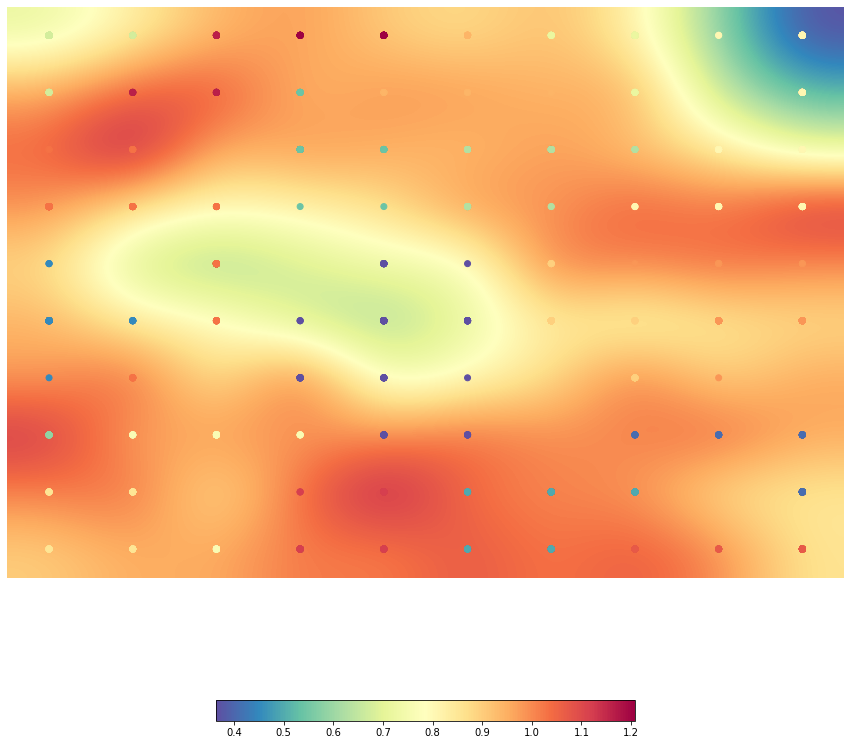

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [ ]:
som_10_2000.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

In [ ]:
clusters = som_10_2000.clusters
_, cl_unique = np.unique(clusters, return_counts = True)
cl_sorted = np.argsort(cl_unique)

print(clusters)
print()
print()
print('Clusters sorted by increasing number of neurons:')
print()
print('Cluster Index')
print(cl_sorted)
print('Number of Neurons')
print(cl_unique[cl_sorted])

[[ 7  7 18 19 19 13  8  8 10 10]
 [ 7 18 18  4 13 13 13  8 10 10]
 [15 15  4  4  4  6  6  6 10 10]
 [15 15 15  4  4  6  6 10 10 10]
 [ 2 15 15 15  0  0 12 14 14 14]
 [ 2  2 15  0  0  0 12 12 14 14]
 [ 2 15  9  0  0  0 12 12 14 14]
 [ 5  9  9  9  0  0  3  1  1  1]
 [11 11  9 17 17  3  3  3  1  1]
 [11 11  9 17 17  3  3 16 16 16]]


Clusters sorted by increasing number of neurons:

Cluster Index
[ 5 19 16  7  8 18  2 17 13 11  1  6 12  9  4  3 14 10 15  0]
Number of Neurons
[ 1  2  3  3  3  3  4  4  4  4  5  5  5  6  6  6  7  9 10 10]



## Semantic interpretation of the clusters
In order to evaluate the performance of our SOM model, we will print for each cluster the movie genres that correspond to it. If a cluster has a dominant category in it, which means that there are many more movies belonging to this category than the rest, then we can say that this cluster corresponds to that category.

In order to achieve this, we are going to implement the following functions:

`print_categories_stats`: This function takes as input a list of movie ids. Then it prints a count of movies belonging to each category.

`print_cluster_neurons_movies_report`: This function takes as input a cluster id. Then it outputs a list of the best matching units that correspond to this cluster.

`neuron_movies_report`: This function takes as input a list of neurons outputted by the print_cluster_neurons_movies_report function. Then using the indices array, creates a list that contains all the movies that correspond to those neurons. Finally, calls the print_categories_stats function to print the results.

Example of an output (from a default model):

```
Overall Cluster Genres stats:  
[('"Horror"', 86), ('"Science Fiction"', 24), ('"B-movie"', 16), ('"Monster movie"', 10), ('"Creature Film"', 10), ('"Indie"', 9), ('"Zombie Film"', 9), ('"Slasher"', 8), ('"World cinema"', 8), ('"Sci-Fi Horror"', 7), ('"Natural horror films"', 6), ('"Supernatural"', 6), ('"Thriller"', 6), ('"Cult"', 5), ('"Black-and-white"', 5), ('"Japanese Movies"', 4), ('"Short Film"', 3), ('"Drama"', 3), ('"Psychological thriller"', 3), ('"Crime Fiction"', 3), ('"Monster"', 3), ('"Comedy"', 2), ('"Western"', 2), ('"Horror Comedy"', 2), ('"Archaeology"', 2), ('"Alien Film"', 2), ('"Teen"', 2), ('"Mystery"', 2), ('"Adventure"', 2), ('"Comedy film"', 2), ('"Combat Films"', 1), ('"Chinese Movies"', 1), ('"Action/Adventure"', 1), ('"Gothic Film"', 1), ('"Costume drama"', 1), ('"Disaster"', 1), ('"Docudrama"', 1), ('"Film adaptation"', 1), ('"Film noir"', 1), ('"Parody"', 1), ('"Period piece"', 1), ('"Action"', 1)]```
   

In [25]:
def print_categories_stats(ids, lim):
  total_categories = []
  for id in ids:
    categs = np.array2string(categories[id])[2:-2].split(',')
    categs = [c.strip().strip().strip('"') for c in categs]
    total_categories.extend(categs)

  c_names ,c_count = np.unique(total_categories, return_counts = True)
  c_sorted = np.argsort(c_count)[::-1][:lim]

  for c in c_sorted:
    print(c_names[c] + " " + str(c_count[c]))

In [26]:
def print_cluster_neurons_movies_report(cluster_id):
  i, j = np.where(clusters == cluster_id)
  idx = np.column_stack((j, i))

  return [bmu for bmu in idx if bmu in unique_bmus]

In [27]:
def neurons_movies_report(neurons, lim=1000):
  ind = []
  for i in range(len(bmus)):
    for neuron in neurons:
      if np.array_equal(bmus[i],neuron):
        ind.append(i)

  movie_ids = [i for i in range(len(indices)) if indices[i] in ind]
  print_categories_stats(movie_ids, lim)

The categories for a random cluster of our 10x10 SOM and their instances in the cluster follow below.

In [ ]:
neurons_movies_report(print_cluster_neurons_movies_report(6), 10)

Drama 100
Comedy 67
Romance Film 42
Action 34
Thriller 33
World cinema 31
Adventure 24
Family Film 24
Black-and-white 23
Horror 20



## SOM and clustering exploration tips

- For good clustering, U-matrix should show clusters with blue-green colors and borders with red (as much as it is possible). Conclusions should be based on number of movies, number of neurons and quality of U-matrix.
- k parameter of k-Means should approximate the number of clusters of U-matrix. Small values for k do not respect the U-matrix borders, while large values tend to create sub-clusters. The latter is not that harmful, but requires more extensive analysis.
- Making observations for smaller maps and smaller final sets, then expanding them to larger maps and the whole movie set.
- Some topological characteristics are visible only for larger maps. Exploration sizes are 20x20, 25x25 and 30x30 with respective values for k.


## Finding optimal SOM

Below we will experiment with different grid sizes and k's (number of neighbors in algorithm), we will examine the topological properties of the produced SOMs and, finally, we will choose the best SOM. We will analyze every SOM using the same procedures from the above steps.

We begin the exploration with grid sizes 20x20, 25x25 and 30x30, similar k values and with just 2000 from our 5000 movies (40%). Then, when we have locked on some parameter values, we are going to use our whole dataset.

In [ ]:
som_20_2000 = somoclu.Somoclu(20, 20)
%time som_20_2000.train(final_set[1500:3500, :], epochs=100)
joblib.dump(som_20_2000, 'map20_2000.pkl')

CPU times: user 15min 54s, sys: 3.59 s, total: 15min 57s
Wall time: 8min 5s


['map20_2000.pkl']

In [ ]:
som_25_2000 = somoclu.Somoclu(25, 25)
%time som_25_2000.train(final_set[1500:3500, :], epochs=100)
joblib.dump(som_25_2000, 'map25_2000.pkl')

CPU times: user 24min 48s, sys: 6.47 s, total: 24min 55s
Wall time: 12min 46s


['map25_2000.pkl']

In [ ]:
som_30_2000 = somoclu.Somoclu(30, 30)
%time som_30_2000.train(final_set[1500:3500, :], epochs=100)
joblib.dump(som_30_2000, 'map30_2000.pkl')

CPU times: user 36min 24s, sys: 9.52 s, total: 36min 33s
Wall time: 18min 45s


['map30_2000.pkl']

In [ ]:
som_20_2000 = joblib.load('map20_2000.pkl')
som_25_2000 = joblib.load('map25_2000.pkl')
som_30_2000 = joblib.load('map30_2000.pkl')

In [ ]:
bmus = som_20_2000.bmus
unique_bmus, indices = np.unique(bmus, return_inverse=True, axis=0)

print(bmus.shape)
print(unique_bmus.shape)
print(indices)

(2000, 2)
(330, 2)
[187 251 329 ... 233  65 311]


#### Observations for 20x20 SOM

Initially, we study the results for k=20. It seems that the results are quite good, but there are some areas where we could have more clusters. Such an example is the top-right corner, where there is a cluster with 52 neurons. The coloring shows that it would be more logical to have 2 clusters at this area. So, we decide to experiment with higher k-values.

k=25 provides us with a solution for the above problematic behaviors. The grid size, however, does not help us with higher k-values.

In [ ]:
algorithm = KMeans(n_clusters=25)
som_20_2000.cluster(algorithm=algorithm) 

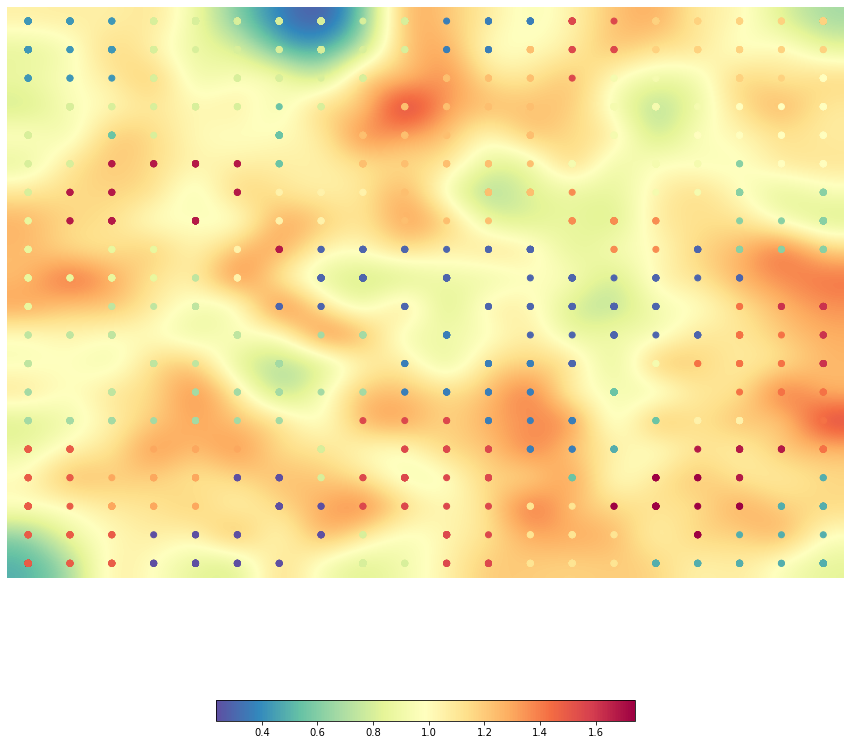

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [ ]:
som_20_2000.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

In [ ]:
clusters = som_20_2000.clusters
_, cl_unique = np.unique(clusters, return_counts = True)
cl_sorted = np.argsort(cl_unique)

print(clusters)
print()
print()
print('Clusters sorted by increasing number of neurons:')
print()
print('Cluster Index')
print(cl_sorted)
print('Number of Neurons')
print(cl_unique[cl_sorted])

[[ 3  3  3  9  9  9  9  9  9  9  2  2  2 21 21 15 15 15 15 15]
 [ 3  3  3  9  9  9  9  9  9  9  2  2 16 21 21 15 15 15 15 15]
 [ 3  3  3  9  9  9  9  9  9 16 16 16 16 21 11 11 15 15 15 12]
 [ 9  9  9  9  9  9  5  9  9 16 16 16 16 11 11 11 11 12 12 12]
 [ 9  9  5  9  9  5  5  5 16 16 16 16 16 11 11 11 12 12 12 12]
 [ 9  9 23 23 23 23  5 13 16 16 16 16 16 11 11 11 11  6 12 12]
 [ 9 23 23 23 23 23 13 13 13 16 16 16 16 18 18 11 11  6  6  6]
 [10 23 23 23 23 23 13 13 13 16 16 16  1 18 18 18 18  6  6  6]
 [10 10 10 10 23 13 23  1  1  1  1  1  1  1 18 18  1  6  6  6]
 [10 10 10 10  8 13  1  1  1  1  1  1  1  1  1  1  1  1  1 22]
 [10 10  8  8  8  8  1  1  1  1  1  1  1  1  1  1  1 19 22 22]
 [ 8  8  8  8  8  8  7  7  7  1  2  2  1  1  1  1  1 19 19 22]
 [ 8  8  8  8  8  7  7  7  7  2  2  2  2  1  5 11 19 19 19 22]
 [ 7  7  8  8  7  7  7  7  7  2  2  2  2  5  5  5  5 19 19 19]
 [ 7  7  7  7  7  7  7  7 21 21 21  2  2  2  5  5 13 13 19 19]
 [20 20 20 17 17 17  9  9  9 21 21 21  2  2  4 24 23 23

In [ ]:
neurons_movies_report(print_cluster_neurons_movies_report(2), 10)

Drama 35
Comedy 20
Thriller 19
Action 14
Animation 11
Crime Fiction 10
Short Film 10
Horror 9
Action/Adventure 9
Family Film 9


#### 20x20 SOM overview

Checking the categories for the clusters of the above SOM, a concern has arised. Most of the clusters contain 'Drama' and 'Comedy' at the top spots. While this is normal, since every movie can more or less be included in at least 1 of those 2 genres. However, we believe that more clusters would provide us with a better separation of the movies. Since we want to increase the k-parameter, we should explore larger grid sizes as well.

#### Observations for 25x25 SOM

Initially, we check k=25. It seems again, that some areas that form 1 cluster could be splitted to more subclusters, considering the colors of the SOM. Such an example is a central area, tha except Dramas and Comedies, contains Romance and Thriller movies too. This variety of movie genres leads us to the conclusion that more clusters could give a better result.

After experimenting with larger k-values, it seems that k=32 gives us the best clustering. Even larger values may work as well, but they tend to create subclusters where they are not necessary. Then, we look at the problematic area we showcased above. There are now 3 or 4 clusters covering the same area. Their genres are again similar, especially for Drama and Comedy, but now they tend to get more specific, each one for a respective genre (action, romance, thrillers etc.)

In [ ]:
bmus = som_25_2000.bmus
unique_bmus, indices = np.unique(bmus, return_inverse=True, axis=0)

print(bmus.shape)
print(unique_bmus.shape)
print(indices)

(2000, 2)
(487, 2)
[ 89 204 425 ... 205 415 136]


In [ ]:
algorithm = KMeans(n_clusters=32)
som_25_2000.cluster(algorithm=algorithm) 

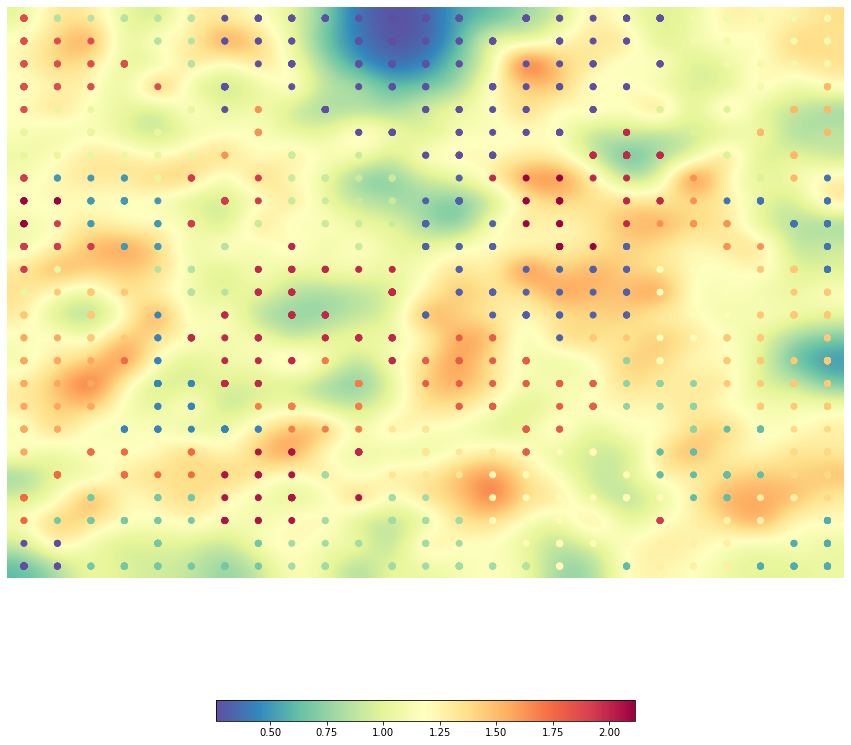

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [ ]:
som_25_2000.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

In [ ]:
clusters = som_25_2000.clusters
_, cl_unique = np.unique(clusters, return_counts = True)
cl_sorted = np.argsort(cl_unique)

print(clusters)
print()
print()
print('Clusters sorted by increasing number of neurons:')
print()
print('Cluster Index')
print(cl_sorted)
print('Number of Neurons')
print(cl_unique[cl_sorted])

[[27 10 10 10 10 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0 14 14 14 14
  14]
 [27 27 27 10 10 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0 14 14 14 14
  14]
 [27 27 27 27 27 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0 12 14 14 14
  14]
 [27 27 27 27 27  0  0  0  0  0  0  0  0  0  0  0  0  0  0 12 12 12 14 21
  21]
 [27 13 13 13 13 13  0 23  0  0  0  0  0  0  0  0  0  0 29 12 12 12 21 21
  21]
 [13 13 13 13 13 13 23 23 23  0  0  0  0  0  0  0  0 29 29 12 12 12 21 21
  21]
 [13 13 13 13 13 13 23 23 11 11 11 11  0  0  0  0 29 29 29 29 12 12 21 21
  21]
 [28  4  4  4 13 28 28 28 11 11 11 11 11  1 29 31 31 29 29 29 23 12 12 21
   2]
 [31 31  4  4  4 28 28 28 11 11 11 11  1  1  1 31 31 31 29 29 23  2  2  2
   2]
 [31 28  4  4  4 28 28 11 11 11 11 11  1  1  1 31 31 31 29 23 23 23  2  2
   2]
 [28 28 28  4  4 10 10 29 29 11 11 29  1  1  1  1 31 31  1  1 23 23 23  2
   2]
 [28 13 20 10 10 10 10 29 29 29 29 29  1  1  1  1  1  1  1 15 15 15 20 20
   2]
 [13 20 20 20 10 10 10 29 29 29 29 29 29

In [ ]:
neurons_movies_report(print_cluster_neurons_movies_report(18), 10)

Drama 13
Romance Film 7
Comedy 5
Thriller 5
Family Film 4
World cinema 3
Romantic drama 3
Action 3
Action/Adventure 2
Romantic comedy 2


#### 25x25 SOM overview

Checking the categories for the clusters of the above SOM, it seems that the results are close to the desired. The fact, that we are allowed to use a greater k-value, has given us clusters that come closer to the u-matrix, which is not ideal (mainly because of our dataset's movies).

#### Observations for 30x30 SOM
Again, the initial k=30 proves to be too small for this grid size, for similar reasons as previously. We will experiment again with larger numbers.

Here, for larger k-values (like 35 or 40), the results on the u-matrix are too confusing. There are less borders between areas and, for many clusters, the neurons tend to populate areas that either should split to two subclusters, or should be given to a nearby cluster. Also, movie genres tend to mix with each other in clusters, while they are not related that much.

In [ ]:
bmus = som_30_2000.bmus
unique_bmus, indices = np.unique(bmus, return_inverse=True, axis=0)

print(bmus.shape)
print(unique_bmus.shape)
print(indices)

(2000, 2)
(640, 2)
[ 60 302 150 ... 407 629  72]


In [ ]:
algorithm = KMeans(n_clusters=40)
som_30_2000.cluster(algorithm=algorithm) 

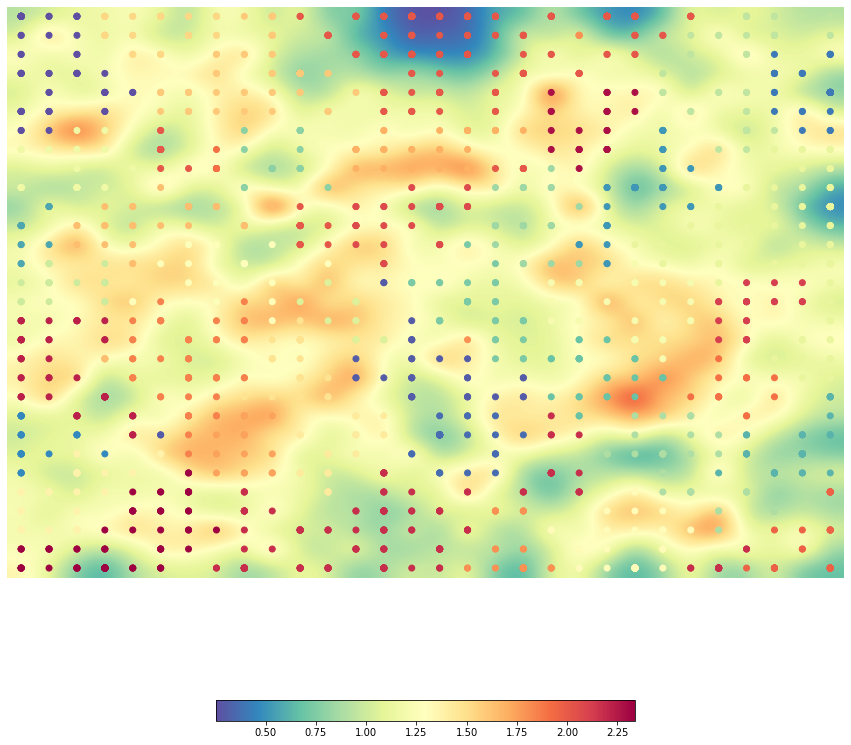

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [ ]:
som_30_2000.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

In [ ]:
clusters = som_30_2000.clusters
_, cl_unique = np.unique(clusters, return_counts = True)
cl_sorted = np.argsort(cl_unique)

print(clusters)
print()
print()
print('Clusters sorted by increasing number of neurons:')
print()
print('Cluster Index')
print(cl_sorted)
print('Number of Neurons')
print(cl_unique[cl_sorted])

[[ 4  4 29 29 29 29 29 29 21 15 23 23 23 23 23 23 23 23 23 23  4  4  4  4
   4 14 14 14 14 14]
 [ 4  4 29 29 29 29 29 29 15 15 23 23 23 23 23 23 23 23 23 23  4  4  4  4
   4 14 14 14 14 14]
 [ 4  4  4 29 29 29 29 15 15 15 15 23 23 23 23 23 23 23 23 23 23  4  4  4
   4 14 14 14 14 14]
 [ 4  4  4  4  4 15 15 15 15 15 15 15 23 23 23 23 23 23 23 23 23 23  4  4
   4  4 14 14 14 14]
 [ 4  4  4  4  4 15 15 15 15 15 15 15 15 23 23 23 23 23 23 24 24 24 24 24
   4 14 14 14 14 14]
 [ 4  4  4  4  4 15 15 15 15 15 15 15 15 23 23 23 23 23 23 24 24 24 24 24
  24 14  2 14 14 14]
 [ 4  4 26 26 23 23 15 23 23 23 23 23 27 27 27 27 23 23 23 24 24 24 24 24
  24  2  2  2 14 14]
 [26 26 26 26 23 23 23 18 23 23 23 23 27 27 27 27 23 23 23 24 24 24 24 24
  24  2  2  2  2  2]
 [26 26 26 26 26 23 16 18 23 23 23 23 27 27 27 23 23 23 23 23 24 24 24 24
  24 21  2  2  2  2]
 [26 26 26 26 26 16 16 16 16 23 23 23 23 23 23 23 23 11 11 11 11 24 24 24
  21 21  2  2  2  2]
 [26 26 26 26 26 16 16 16 16 16  0  0  0 23 23 23 

In [ ]:
neurons_movies_report(print_cluster_neurons_movies_report(24), 10)

Drama 21
Horror 10
Romance Film 10
Comedy 10
Indie 7
Musical 5
Thriller 5
Adventure 5
Black-and-white 5
Crime Fiction 5


#### 30x30 SOM overview

Here, the larger number of neurons gives more confusing results. Many of the clustering areas of the map do not have great distance from one another (not many red areas). Also, the created clusters may differ from one another on one or two movie categories, that are not even in their respective top 4 or 5. This more specialised clustering requires more analysis, while we think that it causes more confusion than it offers clarity.

#### Overall
We are going to test the whole dataset with the 25x25 grid, which seems to be the best from the above options. In case the results are below expectations, we are going to move to larger grid size and evaluate the results.

#### 25x25 SOM on the whole movie set

In [ ]:
som_25_final = somoclu.Somoclu(25, 25)
%time som_25_final.train(final_set, epochs=100)
joblib.dump(som_25_final, 'map25_final.pkl')

CPU times: user 1h 1min 38s, sys: 15.2 s, total: 1h 1min 53s
Wall time: 31min 51s


['map25_final.pkl']

We begin with k=25. There are already many positive observations regarding the clusters and the map. There are not many red areas (borders between regions), but this is normal for a larger size of movies, that may bring "bridges" to gaps between clusters. For the majority of the clusters, it is true that they are formed around a blue-green area, meaning close distance between the neurons.

Continuing with the experimentation of parameter k=30 and other values around that, offer even better results. Most clusters can be easily connected to their colored area of the map, while they are not overmixed with other clusters.

In [31]:
som_25_final = joblib.load('map25_final.pkl')

In [32]:
bmus = som_25_final.bmus
unique_bmus, indices = np.unique(bmus, return_inverse=True, axis=0)

print(bmus.shape)
print(unique_bmus.shape)
print(indices)

(5000, 2)
(540, 2)
[248 528  94 ... 154  55 477]


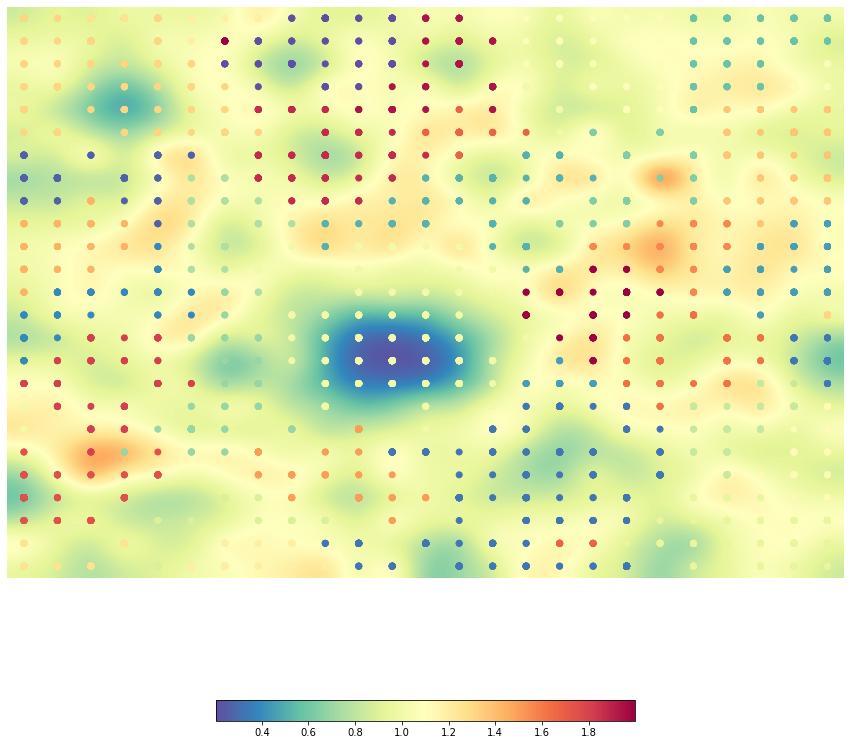

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [34]:
algorithm = KMeans(n_clusters=30)
som_25_final.cluster(algorithm=algorithm)
som_25_final.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

In [35]:
clusters = som_25_final.clusters
_, cl_unique = np.unique(clusters, return_counts = True)
cl_sorted = np.argsort(cl_unique)

print(clusters)
print()
print()
print('Clusters sorted by increasing number of neurons:')
print()
print('Cluster Index')
print(cl_sorted)
print('Number of Neurons')
print(cl_unique[cl_sorted])

[[18 18 17 17 18 16 16 16  0  0  0  0 28 28 14 14 14 14 14 14  6  6  6  6
   6]
 [18 18 18 18 18 16 29  0  0  0  0  0 28 28 28 14 14 14 14 14  6  6  6  6
   6]
 [18 18 18 18 18 18  0  0  0  0  0  0 28 28 28 14 14 14 14 14  6  6  6  6
  14]
 [18 18 18 18 18 18 18  0  0  0  0 28 28 28 28 13 14 14 14 14  6  6  6 14
  14]
 [18 18 18 18 18 18 18 27 27 27 28 28 28 24 28 13 13 14 14 14  6 19 19 19
  19]
 [18 18 18 18 18 18 18 18 27 27 27 27 24 24 24 24 13  7  7  7  7 19 19 19
  19]
 [ 1  1  1  1  1  1 27 27 27 27 27 27 27 24  5  5  5  7  7  7  7 19 19 19
  19]
 [ 1  1  1  1  1  9  9 27 27 27 27 27  5  5  5  5  5  5  7  7  7 19 19 19
  19]
 [ 1  1 20  1  1  9  9  9 27 27 27  5  5  5  5  5  5  7  7  7  7 19 19 19
  19]
 [20 20 20 20  1  9  9  9  9  5  5  5  5  5  5  5  7  7  7 22 22 22 19  4
   4]
 [20 20 20 20  3  9  9  9 13  5 13 13 13 13  5  5  5 22 22 22 22 22  4  4
   4]
 [20 20 20  3  3  9  9 13 13 13 13 13 13 13 13  5  5 29 29 22 22  4  4  4
   4]
 [20  3  3  3  3  3  8  9 13 13 13 13 13

In [150]:
neurons_movies_report(print_cluster_neurons_movies_report(5), 10)

Short Film 73
Drama 51
Comedy 46
Romance Film 33
Comedy-drama 23
Adventure 19
Indie 18
World cinema 14
Horror 13
Black-and-white 11


## Analysis of SOM topological characteristics

For the 2nd part of the lab, we used the tfidf recommender system with about 3500 words. The addition of the 322 categories (10% of the words) means that the words are going to dominate the clustering procedure. Thus, when comparing different clusters, it is normal to see some common genres (like Drama or Comedy, which are the most frequent and every movie can relate to one of them). The difference between the clusters is more distinct when we examine the top 10 genres of a cluster.

- Cluster with most frequent features tends to include more neurons and vice versa.

We are going to check our two largest clusters, 13 and 18, to observe the above behavior. Then, we are going to check our two smallest clusters, 24 and 17.

In [65]:
neurons_movies_report(print_cluster_neurons_movies_report(13), 10)

Drama 317
Comedy 194
Thriller 168
Action 117
Crime Fiction 100
Action/Adventure 86
Black-and-white 77
Romance Film 68
Short Film 65
Documentary 63


In [66]:
neurons_movies_report(print_cluster_neurons_movies_report(18), 10)

Drama 365
Romance Film 149
Comedy 93
Indie 85
Black-and-white 79
Short Film 77
World cinema 65
Family Film 65
Adventure 53
Science Fiction 47


Examining the largest clusters, we can see that they are dominated by some of the most common movie genres across our dataset. These are primarily Drama and Comedy, while Thrillers, Action movies and Romance films are the next most popular ones.

In [67]:
neurons_movies_report(print_cluster_neurons_movies_report(24), 10)

Comedy 11
Drama 10
Mystery 9
Romance Film 7
Horror 7
Musical 5
Japanese Movies 5
Crime Fiction 3
Family Film 3
Detective 3


In [68]:
neurons_movies_report(print_cluster_neurons_movies_report(17), 10)

Drama 49
Thriller 46
Horror 38
Silent film 38
Action 32
Comedy 19
Psychological thriller 17
Science Fiction 17
Romance Film 16
Cult 14


Since categories do not have a major role in the clustering process, it is normal to see many popular genres again. The follow-up categories offer some clarity. For cluster 24, Japanese Movies and Horror are two of the printed categories. This creates a more unique cluster, containing movies of this type mainly. Such an example is the movie "Dead Air!" we tested in the first part of the lab. For the cluster 17, we observe a similar pattern, with Silent film, Psychological Thriller and Cult.

- Unrelated movies seem to be distant in the map (red-ish area separates them)

We are going to check the cluster pairs 25-26 and 5-27. They are some of the few cluster pairs in our map that seem to be distant.

In [73]:
neurons_movies_report(print_cluster_neurons_movies_report(25), 10)

Action 76
Drama 48
Romance Film 32
Black-and-white 28
Comedy 26
Romantic drama 22
Film adaptation 15
Crime Fiction 14
Romantic comedy 13
Action/Adventure 12


In [74]:
neurons_movies_report(print_cluster_neurons_movies_report(26), 10)

Drama 74
World cinema 30
Crime Fiction 30
Thriller 24
Crime Thriller 17
Mystery 13
Art film 12
Film adaptation 11
Japanese Movies 11
Romance Film 10


We can see that the most common category (Drama) is popular for both of the clusters, but the rest of the categories differ significantly. While cluster 25 is focused more on Action, Comedy and subcategories of Romance, the cluster 26 focuses more on World Cinema, Thrillers and Crime movies.

In [75]:
neurons_movies_report(print_cluster_neurons_movies_report(5), 10)

Short Film 73
Drama 51
Comedy 46
Romance Film 33
Comedy-drama 23
Adventure 19
Indie 18
World cinema 14
Horror 13
Black-and-white 11


In [76]:
neurons_movies_report(print_cluster_neurons_movies_report(27), 10)

Thriller 32
Horror 31
Action 30
Comedy 22
Documentary 17
Action/Adventure 16
Short Film 15
Drama 14
Adventure 14
Indie 13


Again, the distinction is clear. Cluster 5 focuses mainly on Short Films (!!!), Comedies and Romance, while cluster 27 focuses more on Thrillers and horror movies.

- Related seem to be closer in the map (blue-ish areas)

One of the best cluster pairs that showcases this characteristic is 26-8, that are separated by a green area.

In [77]:
neurons_movies_report(print_cluster_neurons_movies_report(8), 10)

Drama 18
Thriller 16
World cinema 15
Crime Thriller 15
Animation 13
Crime Fiction 13
Family Film 11
Film noir 9
Fantasy 9
Children\'s/Family 7


In [78]:
neurons_movies_report(print_cluster_neurons_movies_report(26), 10)

Drama 74
World cinema 30
Crime Fiction 30
Thriller 24
Crime Thriller 17
Mystery 13
Art film 12
Film adaptation 11
Japanese Movies 11
Romance Film 10


It is clear that most of the top categories are common for the two clusters, such as Drama, World Cinema, Crime Fiction, Thriller and Crime Thriller.

- Clusters without recognizable behaviour

In [86]:
neurons_movies_report(print_cluster_neurons_movies_report(12), 10)

Drama 157
Comedy 57
Crime Fiction 57
Romance Film 47
Horror 45
Indie 40
Comedy film 35
World cinema 30
Musical 22
Melodrama 20


Cluster 12, one of our largest clusters, has some top categories that are not easily related with one another, such as Crime Fiction, Romance, Horror and Comedy. A possible explanation is that Drama is the main category for most of the movies and these are just subcategories.

In [96]:
neurons_movies_report(print_cluster_neurons_movies_report(24), 10)

Comedy 11
Drama 10
Mystery 9
Romance Film 7
Horror 7
Musical 5
Japanese Movies 5
Crime Fiction 3
Family Film 3
Detective 3


Cluster 24, our smallest from the movie set, has many genres that make it difficult to pinpoint its thematic center. Mystery, Romance, Horror, Musical and Family films all lead us to different directions. Probably, this is caused by the small number of movies that are included in this cluster and, also, by the fact that more than 90% of tfidf vectorizer contents are words from summaries, not categories.

- Clusters without topologically related neighbors

We are going to test cluster 29 and some of its its neighbors (4, 22, 13)

In [114]:
neurons_movies_report(print_cluster_neurons_movies_report(29), 10)

World cinema 55
Drama 54
Comedy film 48
Comedy 26
Family Film 12
Action/Adventure 8
Musical 5
Japanese Movies 4
Comedy-drama 3
Romantic drama 3


Cluster 29 seems to contain mostly World Cinema movies, from subcategories of Comedy and Drama genres.

In [115]:
neurons_movies_report(print_cluster_neurons_movies_report(4), 10)

Crime Fiction 48
Drama 43
Thriller 29
Adventure 24
Comedy 20
Action 17
Action/Adventure 17
Black comedy 16
Crime Drama 11
Comedy-drama 11


Cluster 4 seems to attract Crime Fiction movies, Thrillers and Adventures mostly, far from cluster 29. (also top category of cluster 29 - World Cinema - is not included in cluster 4's top categories)

In [117]:
neurons_movies_report(print_cluster_neurons_movies_report(22), 10)

Comedy 43
Black-and-white 39
Thriller 26
Drama 24
Mystery 18
Musical 14
Action/Adventure 12
Action 11
Science Fiction 9
Romance Film 8


Cluster 22 likewise does not contain many (or any) World Cinema movies. Even though Comedy and Drama are common categories for both, the rest of the categories differ among them.

In [119]:
neurons_movies_report(print_cluster_neurons_movies_report(13), 10)

Drama 317
Comedy 194
Thriller 168
Action 117
Crime Fiction 100
Action/Adventure 86
Black-and-white 77
Romance Film 68
Short Film 65
Documentary 63


Comparing cluster 29 with 13, one of its largest neighbors the distinction is again quite clear. Except Comedy and Drama, the most common genres among the movie set, cluster 13 focuses more on Thrillers and Action/Adventure movies, while 29 focuses more on Comedies and Romantic films.

The reasons for the above differences, in our opinion, are:

- The major role of summary words in the distinction of movies. This means that movies could be similar in terms of the plot, but because of the film's atmosphere, they are included in different categories.

- When trying to appoint a movie to a cluster, it is normal and expected that some neighbor-clusters differ in some key aspects. In that way, if a movie is not similar to the thriller/action movies of 13, it could move towards a different area that may be closer to it, like 29 with comedy/romance films.

- Clusters with interesting behavior



One cluster that really drew our attention was the cluster 5. Its movies' most popular category is Short Film. This is quite unexpected, because short films cannot be connected easily with each other, since their movie genres could significantly vary. This is enhanced by the next most popular categories, that are several different movie genres.

Another cluster close to it in the map is cluster 14. Its second most popular category is animation films. Many animation films are usually short and they also include many movie genres.

In [151]:
neurons_movies_report(print_cluster_neurons_movies_report(5), 10)

Short Film 73
Drama 51
Comedy 46
Romance Film 33
Comedy-drama 23
Adventure 19
Indie 18
World cinema 14
Horror 13
Black-and-white 11


In [152]:
neurons_movies_report(print_cluster_neurons_movies_report(14), 10)

Drama 48
Animation 36
Black-and-white 23
Comedy 19
Science Fiction 18
Action 17
Short Film 17
Indie 13
Romance Film 13
War film 11


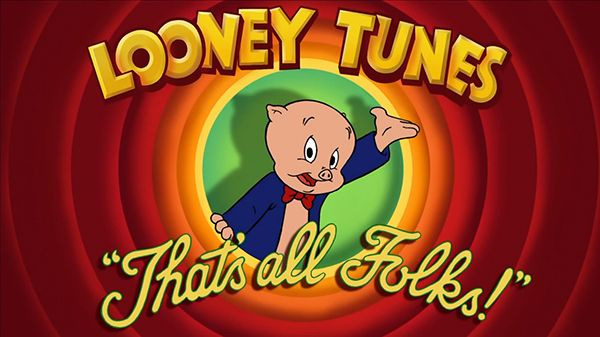